## Image Registration using Enhanced Correlation Coefficient (ECC) Maximization

Image registration after applying some binary thresholding. 

In [1]:
import numpy as np
import cv2
from skimage.external import tifffile as tiff
from skimage.util import img_as_float
from skimage import exposure
from skimage.filters import try_all_threshold, threshold_li, threshold_adaptive
from skimage.transform import rescale
from skimage.transform import warp, AffineTransform, resize
from skimage.color import rgb2gray
from skimage.exposure import rescale_intensity

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline


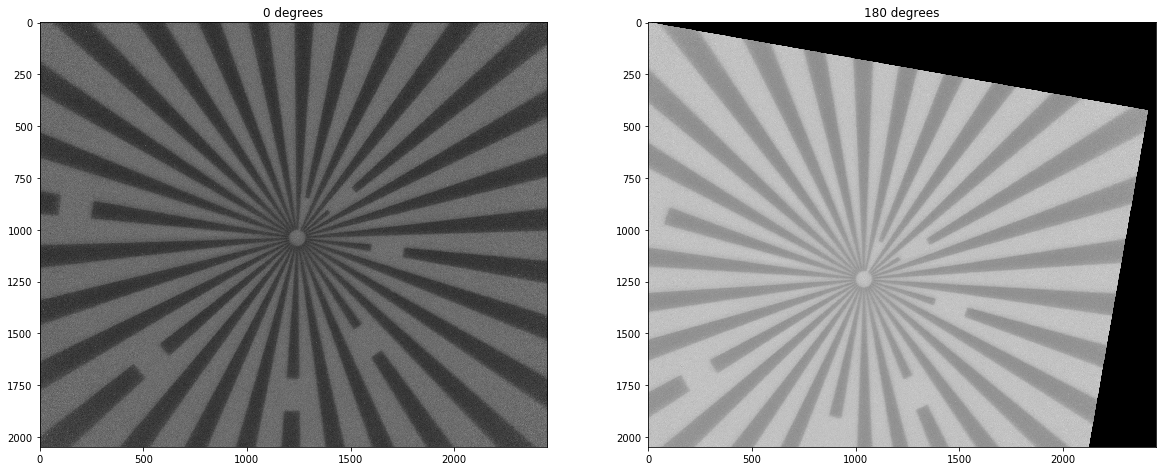

In [2]:
samples = ['../samples/rot_0.tif', 
           '../samples/rot_180.tif',
           '../samples/faked_rot_0_tilted_5.3deg.tif',
           '../samples/faked_rot_180.tif']

img0deg = tiff.imread(samples[0])

tform = AffineTransform(rotation=10 *  np.pi/180)
img180deg = warp(img0deg, tform.inverse, output_shape=(img0deg.shape[0], img0deg.shape[1]))


# img180deg = tiff.imread(samples[2])
# img180deg = cv2.flip(img180deg, 1)

fig = plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(img0deg, cmap='gray')
plt.title("0 degrees")
plt.subplot(122)
plt.imshow(img180deg, cmap='gray')
plt.title("180 degrees")
plt.show()


In [5]:
def preProcess(image, rs=0.3):
    tmp = rescale(image, rs, mode='reflect')
    tmp = rescale_intensity(tmp)
    
    thresh = threshold_adaptive(tmp, 15)
    binary = tmp > thresh
    result = np.zeros_like(binary, dtype=np.uint8)
    result[~binary] = 255
    
    h, w = result.shape
    result_masked = result.copy()
    mask = np.zeros_like(result, dtype=np.uint8)

    vertices = np.array([[
                    (w/2 - 50, h/2 - 45),
                    (w/2 + 60, h/2 - 45), 
                    (w/2 + 60, h/2 + 50), 
                    (w/2 - 50, h/2 + 50)
                ]], 
                            dtype=np.int32)

    cv2.fillPoly(mask, vertices, 255)
    masked = cv2.bitwise_and(result_masked, mask)
    result_masked[masked > 0] = 0

    
    return result_masked

def computeRotation(img0, img1):
    sz = img0.shape
    warp_mode = cv2.MOTION_TRANSLATION

    warp_matrix = np.eye(2, 3, dtype=np.float32)

    number_of_iterations = 5000
    termination_eps = 1e-10

    criteria = (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, number_of_iterations,  termination_eps)

    # Run the ECC algorithm. The results are stored in warp_matrix.
    (cc, warp_matrix) = cv2.findTransformECC (img0, img1, warp_matrix, warp_mode, criteria)

    print (warp_matrix)
    
    sin = warp_matrix[0, 1]
    cos = warp_matrix[0, 0]
    
    degs = np.arctan2(sin, cos) * 180.0 / np.pi
    
    return degs

/local/fkhan/anaconda3/envs/RoboND/lib/python3.5/site-packages/skimage/filters/thresholding.py:222: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
/local/fkhan/anaconda3/envs/RoboND/lib/python3.5/site-packages/skimage/filters/thresholding.py:224: UserWarning: The return value of `threshold_local` is a threshold image, while `threshold_adaptive` returned the *thresholded* image.
  warn('The return value of `threshold_local` is a threshold image, while '
/local/fkhan/anaconda3/envs/RoboND/lib/python3.5/site-packages/skimage/filters/thresholding.py:222: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,
/local/fkhan/anaconda3/envs/RoboND/lib/python3.5/site-packages/skimage

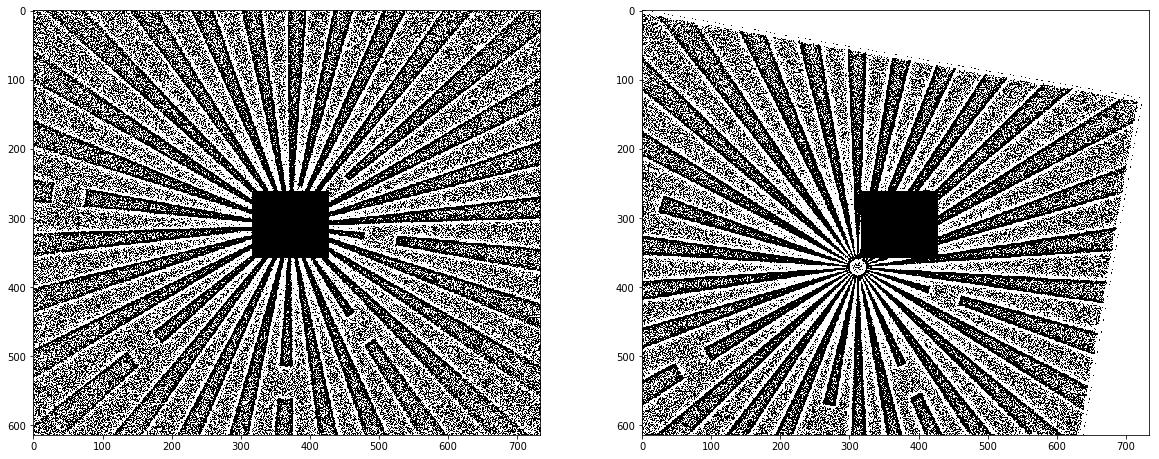

In [6]:
img0 = preProcess(img0deg)
img1 = preProcess(img180deg)

f, ax = plt.subplots(1, 2, figsize=(20,20))

ax[0].imshow(img0, cmap='gray')
ax[1].imshow(img1, cmap='gray')

In [ ]:
print (computeRotation(img1, img0))